# 银行欺诈交易的检测-intel加速
* 使用了参数格搜索和交叉检测
* 分别训练随机森林模型和Xgboost模型，获取F1和time指标

In [20]:
import os
import pickle
import modin.pandas as pd # intel
import modin.config as cfg # intel
cfg.StorageFormat.put('hdk')
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer,precision_recall_curve, auc, f1_score, accuracy_score
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearnex import patch_sklearn # intel
patch_sklearn() # intel

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


读取数据

In [21]:
start_time=time.time()
print("Reading Data...")
data = pd.read_csv("./creditcard.csv")
print("Reading finished")
print("read time: ",time.time()-start_time)

Reading Data...
Reading finished
read time:  0.1912703514099121


数据预处理

In [22]:
start_time=time.time()
print("Processing Data...")
print(data.isnull().sum()) # 缺失值检查
data = data.dropna()  # 直接丢失含有缺失值的行记录
data.info()   # 异常值检查
print(data.Class.unique())  # Class列取值检查

# df["days"], df["hours"], df["minutes"], df["seconds"] = zip(*df["Time"].map(convert_seconds))   # 拆分Time特征
# plt.figure(figsize=(15,15))
# for i in range(0,data.shape[1]-1):
#     plt.subplot(6,5,i+1)
#     sns.distplot(data.iloc[:,i],kde=True)
# plt.show()
# 提取特征数据，去除不需要的列
features = data.drop(["Time","Class"], axis=1)
features=np.array(features)
# 计算每个特征的Z-score
z_scores = np.abs(stats.zscore(features))
# 设置离群值的阈值
threshold = 30
# 检测离群值
outliers = np.where(z_scores > threshold)
# 去除离群值所在的行
data = data.drop(outliers[0], axis=0)

# # 连续变量离散化
# list = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13',
#         'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
#     'V26', 'V27', 'V28', 'NormalAmount']
# for column in list:
#     df = [[x] for x in data[column]]
#     kmeans = KMeans(n_clusters=6, random_state=0).fit(df)
#     data[column] = kmeans.labels_

# 标准化Amount属性，使量级相同
data['NormalAmount']=StandardScaler().fit_transform(np.array(data.Amount).reshape(-1,1))
print(data.describe().iloc[:,-8:])

Processing Data...
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


<class 'modin.pandas.dataframe.DataFrame'>
Index: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

                 V24            V25            V26            V27  \
count  284720.000000  284720.000000  284720.000000  284720.000000   
mean       -0.000146       0.000250       0.000019       0.000092   
std         0.605382       0.517320       0.482014       0.387883   
min        -2.836627      -4.541819      -1.855355      -9.390980   
25%        -0.354583      -0.317062      -0.326967      -0.070815   
50%         0.040920       0.016596      -0.052134       0.001344   
75%         0.439406       0.350682       0.240945       0.091015   
max         4.022866       5.541598       3.517346      10.507884   

                 V28         Amount          Class  NormalAmount  
count  284720.000000  284720.000000  284720.000000  2.847200e+05  
mean       -0.001161      87.410228       0.001696  6.348766e-17  
std         0.288408     228.733735       0.041153  1.000002e+00  
min        -8.656570       0.000000       0.000000 -3.821491e-01  
25%        -0.052957       5.590000       0

特征列和目标列

In [23]:
feature_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
            'V12', 'V13',
            'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
            'V26', 'V27', 'V28', 'NormalAmount']
features = data[feature_cols]
target = data['Class']
print("Processing Data finished")
print("Processing Data time: ",time.time()-start_time)

Processing Data finished
Processing Data time:  1.6579704284667969


划分训练集和测试集

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

训练集中处理不平衡问题

In [25]:
sm=SMOTE(sampling_strategy=1/200,random_state=42)
print('Original dataset shape %s' % Counter(y_train))
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
X_train = pd.DataFrame(X_res, columns=X_train.columns)
y_train = pd.Series(y_res, name='Class')

Original dataset shape Counter({0: 227384, 1: 392})


Resampled dataset shape Counter({0: 227384, 1: 1136})


定义F1作为评价指标

In [26]:
f1_scorer = make_scorer(f1_score)

随机森林模型

In [27]:
rf_model = RandomForestClassifier(random_state=42)

定义参数网格

In [41]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

训练随机森林模型（若存在则直接读取）

In [42]:
start_time = time.time()
model_file = 'random_forest_model_full_intel.pkl'
if os.path.exists(model_file):
    with open(model_file, 'rb') as file:
        best_rf_model = pickle.load(file)
else:
    # 使用StratifiedKFold进行分层交叉验证
    cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # 使用GridSearchCV进行参数搜索和交叉验证
    grid_search_rf = GridSearchCV(rf_model, param_grid_rf, scoring=f1_scorer, cv=cv_rf)
    grid_search_rf.fit(X_train, y_train)
    # 获取最佳参数的模型
    best_rf_model = grid_search_rf.best_estimator_    
    with open('random_forest_model_full_intel.pkl', 'wb') as file:
        pickle.dump(best_rf_model, file)
training_time_rf = time.time() - start_time

在测试集上预测

In [43]:
start_time = time.time()
y_pred_rf = best_rf_model.predict(X_test)
predicting_time_rf = time.time() - start_time

计算F1分数和准确度

In [44]:
f1_rf = f1_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

输出结果

In [45]:
print("Random Forest:")
print("F1 Score: {:.4f}".format(f1_rf))
print("Accuracy: {:.4f}".format(accuracy_rf))
print("Training Time: {:.4f} seconds".format(training_time_rf))
print("Predicting Time: {:.4f} seconds".format(predicting_time_rf))

Random Forest:
F1 Score: 0.8537
Accuracy: 0.9996
Training Time: 0.0331 seconds
Predicting Time: 0.0778 seconds


计算AUPRC

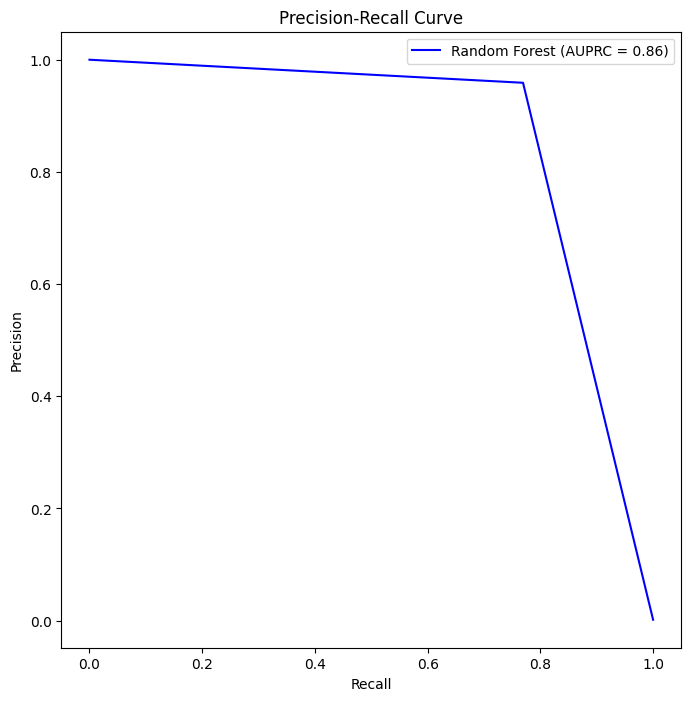

In [46]:
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
auprc_rf = auc(recall_rf, precision_rf)
plt.figure(figsize=(8, 8))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUPRC = {auprc_rf:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

## 使用XGBoost

In [54]:
xgb_model = XGBClassifier(random_state=42)

定义网格参数

In [55]:
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

训练xgboost模型（若存在则直接读取）

In [56]:
start_time = time.time()
model_file = 'xgboost_model_full_intel.pkl'
if os.path.exists(model_file):
    with open(model_file, 'rb') as file:
        best_xgb_model = pickle.load(file)
else:
    # 使用StratifiedKFold进行分层交叉验证
    cv_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    # 使用GridSearchCV进行参数搜索和交叉验证
    grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, scoring=f1_scorer, cv=cv_xgb)
    grid_search_xgb.fit(X_train, y_train)
    # 获取最佳参数的模型
    best_xgb_model = grid_search_xgb.best_estimator_    
    with open('xgboost_model_full_intel.pkl', 'wb') as file:
        pickle.dump(best_xgb_model, file)
training_time_xgb = time.time() - start_time

在预测集上预测

In [57]:
start_time = time.time()
y_pred_xgb = best_xgb_model.predict(X_test)
predicting_time_xgb = time.time() - start_time

计算F1分数和准确度

In [58]:
f1_xgb = f1_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

结果

In [59]:
print("\nXGBoost:")
print("F1 Score: {:.4f}".format(f1_xgb))
print("Accuracy: {:.4f}".format(accuracy_xgb))
print("Training Time: {:.4f} seconds".format(training_time_xgb))
print("Predicting Time: {:.4f} seconds".format(predicting_time_xgb))


XGBoost:
F1 Score: 0.8588
Accuracy: 0.9996
Training Time: 949.7763 seconds
Predicting Time: 0.0934 seconds


计算AUPRC

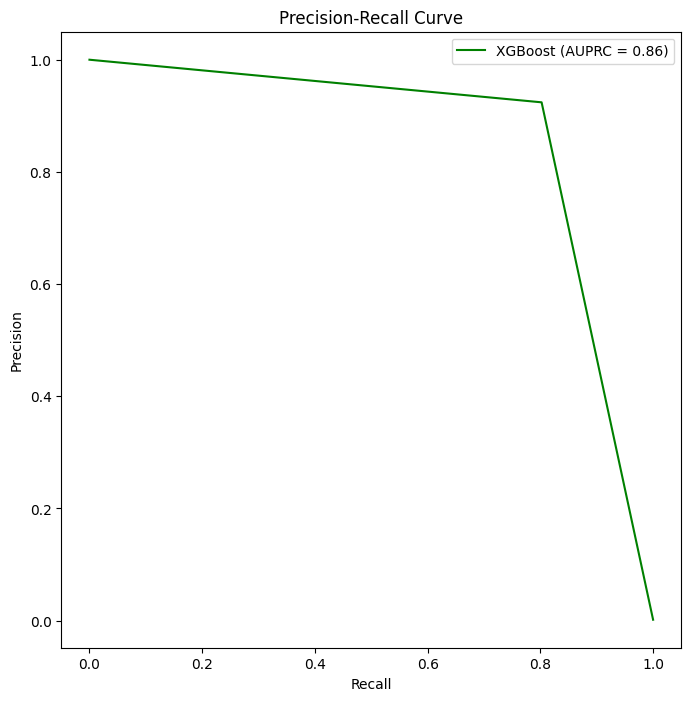

In [60]:
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
auprc_xgb = auc(recall_xgb, precision_xgb)
plt.figure(figsize=(8, 8))
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUPRC = {auprc_xgb:.2f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()